In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from astropy.io import fits
from astropy.wcs import WCS
from scipy.interpolate import UnivariateSpline

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Tue May 26 22:50:43 2020...


In [3]:
def cal_freq(ch):
    v_min=856.0 
    v_max=1712.0 
    dv=0.208984375
    assert((v_max-v_min)/dv==4096)
    freq_MHz=ch*dv+v_min
    freq=freq_MHz*1e6
    return freq

In [4]:
pix_deg=0.3
ptr_pix=np.loadtxt('radio_source_pix_'+str(pix_deg)+'deg.txt')
ptr_ra_pix,ptr_dec_pix=ptr_pix[:,0],ptr_pix[:,1]

output_file='./'

In [5]:
ch_plot=800
fname_list=['1551037708','1551055211','1553966342','1554156377','1556052116','1556138397','1562857793']

# try to load merged but unfiltered data

In [6]:
total_count_MAX=371 #371 in total for level5 result

(133, 41, 4096)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133


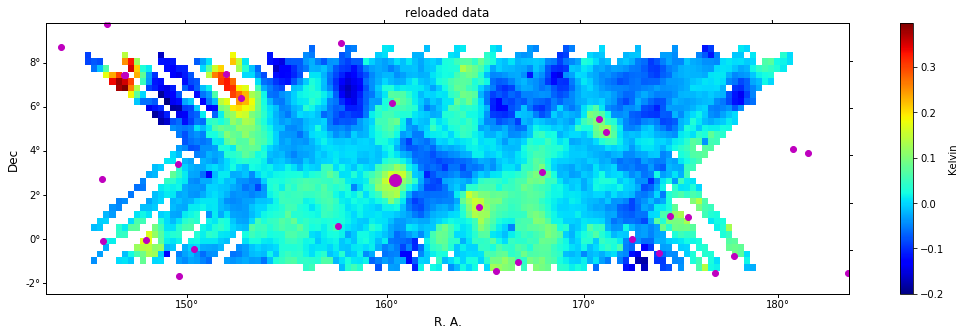

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


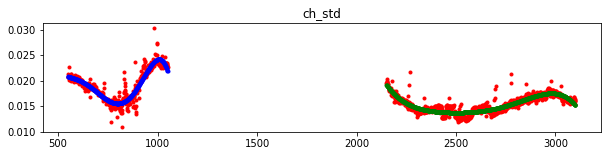

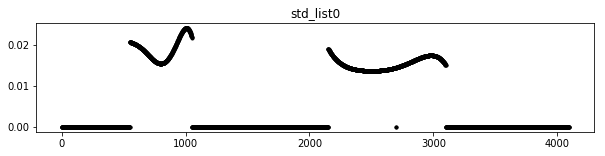

In [7]:
try:
    Fits='/idia/projects/hi_im/raw_vis/katcali_output/level6_output/ALL/ALL_scan'+str(total_count_MAX)+'_Tresi_cube_p'+str(pix_deg)+'d.fits'
    Tresi_cube = fits.open(Fits)[0].data
    print np.shape(Tresi_cube)

    Npix_x= np.shape(Tresi_cube)[0]
    Npix_y= np.shape(Tresi_cube)[1]

    w2=WCS(Fits).dropaxis(-1)
    print w2

    plt.figure(figsize=(18,5))
    plt.subplot(projection=w2)
    plt.imshow(Tresi_cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A.',fontsize=12)
    plt.ylabel('Dec',fontsize=12)
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    plt.title('reloaded data')
    plt.show()
    
    
    Tresi_ra_mean=np.nanmean(Tresi_cube,axis=0) #always check Tresi since Tsky have the Galactic slope 
    ch_std=np.nanstd(Tresi_ra_mean,axis=0) 

    a1,b1,a2,b2=[],[],[],[]
    for i in range(len(ch_std)):
        if np.isnan(ch_std[i])==False: 
            if i< 1051: 
                a1.append(i)
                b1.append(ch_std[i])
            if i> 1051: 
                a2.append(i)
                b2.append(ch_std[i])
    a1,b1,a2,b2=np.array(a1),np.array(b1),np.array(a2),np.array(b2)
    l1=UnivariateSpline(a1,b1,k=5,s=None)(a1)
    l2=UnivariateSpline(a2,b2,k=5,s=None)(a2)

    plt.figure(figsize=(10,2))
    plt.plot(ch_std,'r.')
    plt.plot(a1,l1,'b.')
    plt.plot(a2,l2,'g.')
    plt.title('ch_std')
    plt.show()

    std_list0=np.zeros(4096)
    std_list0[a1]=l1
    std_list0[a2]=l2


    plt.figure(figsize=(10,2))
    plt.plot(std_list0,'k.')
    plt.title('std_list0')
    plt.show()
except IOError:
    std_list0=np.ones(4096)*1e3
    print '*** No previous data cube'


In [8]:
print std_list0

[ 0.  0.  0. ...,  0.  0.  0.]


# filter data and merge

In [9]:
total_count=0 #cube count
total_count_plot=0 #channel count

for a_i in range(64):
    ant='m'+ "%03d" % a_i
    #print ant
    
    for f_i in range(len(fname_list)):
        fname=fname_list[f_i]
        #print fname
        
        try:

            Fits1='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/Tmap/'+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
            Tsky_cube = fits.open(Fits1)[0].data
            Fits2='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/Tmap/'+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits2)[0].data
            assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
            assert((np.isnan(Tresi_cube)).all()==False)
            if (np.isnan(Tsky_cube)).all()==False: #channel count
                total_count+=1 #cube count
            else:
                print '***empty cube'
                
            if (total_count==1):
                Npix_x= np.shape(Tsky_cube)[0]
                Npix_y= np.shape(Tsky_cube)[1]

                w=WCS(Fits1).dropaxis(-1)
                w2=WCS(Fits2).dropaxis(-1)
                assert(w.wcs==w2.wcs)
                print '-------------------------------------------'
                #print w
                print '-------------------------------------------'
                fits_temp=np.zeros([Npix_x,Npix_y,4096])

                Sum_Tsky_xy=fits_temp.copy()
                Sum_Tresi_xy=fits_temp.copy()
                Npix_xy_count1=fits_temp.copy()
                Npix_xy_count2=fits_temp.copy()

                print '***stastic cubes initialized'
                
            print '# cube '+str(total_count)+': '+fname+' '+ant
            assert(np.shape(Tsky_cube)==np.shape(Sum_Tsky_xy))
            
                 
            #mean along dec to check rfi lines
            Tresi_ra_mean=np.nanmean(Tresi_cube,axis=0) #always check Tresi since Tsky have the Galactic slope 
            ch_std=np.nanstd(Tresi_ra_mean,axis=0) 
            
            print 'Tresi ch_std range of '+ ant +' before channel clean: ('+ str(np.nanmin(ch_std))+', '+str(np.nanmax(ch_std))+'), ',
            print 'of ch'+str(ch_plot)+': '+ str(ch_std[ch_plot])
            
            #delete bad channels
            lim_list=std_list0*5.
            ch_drop=np.where(ch_std>lim_list)[0] 

            if len(ch_drop)>0:
                Tsky_cube[:,:,ch_drop]=np.nan            
                Tresi_cube[:,:,ch_drop]=np.nan
                print '***'+str(len(ch_drop))+' channels deleted'
                
            Sum_Tsky_xy[~np.isnan(Tsky_cube)]+=Tsky_cube[~np.isnan(Tsky_cube)]
            Sum_Tresi_xy[~np.isnan(Tresi_cube)]+=Tresi_cube[~np.isnan(Tresi_cube)]
            Npix_xy_count1[~np.isnan(Tsky_cube)]+=1
            Npix_xy_count2[~np.isnan(Tresi_cube)]+=1
            if (np.isnan(Tsky_cube[:,:,ch_plot])).all()==False: #channel count
                total_count_plot+=1
            
        except IOError:
            print 'no data cube for '+ fname+', '+ant


-------------------------------------------
-------------------------------------------
***stastic cubes initialized
# cube 1: 1551037708 m000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in greater


Tresi ch_std range of m000 before channel clean: (0.0154959332132, 0.0592012200169),  of ch800: 0.025868670276
# cube 2: 1551055211 m000
Tresi ch_std range of m000 before channel clean: (0.0219321607571, 0.0396161645055),  of ch800: 0.0273214256521
# cube 3: 1553966342 m000
Tresi ch_std range of m000 before channel clean: (0.021377667316, 0.110528399112),  of ch800: 0.0350333164645
***15 channels deleted
# cube 4: 1554156377 m000
Tresi ch_std range of m000 before channel clean: (0.0178874108884, 0.0410848790106),  of ch800: 0.0278793069043
# cube 5: 1556052116 m000
Tresi ch_std range of m000 before channel clean: (0.0226399812338, 0.0668548681247),  of ch800: 0.0299450843419
# cube 6: 1556138397 m000
Tresi ch_std range of m000 before channel clean: (0.0262526939992, 0.0764483070496),  of ch800: 0.0296455142016
no data cube for 1562857793, m000
no data cube for 1551037708, m001
# cube 7: 1551055211 m001
Tresi ch_std range of m001 before channel clean: (0.0299141630714, 0.0779782678624),

In [10]:
print np.nanmax(Npix_xy_count1)

302.0


In [11]:
Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
Tresi_xy=Sum_Tresi_xy/Npix_xy_count2


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


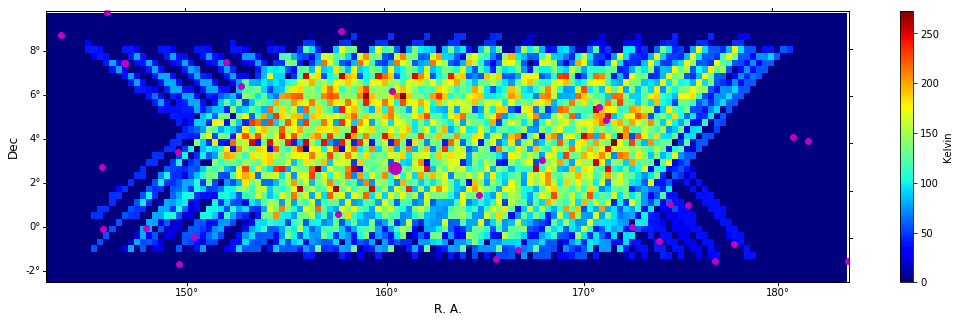

In [12]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.imshow(Npix_xy_count1[:,:,ch_plot].T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

In [13]:
np.nanmax(Tsky_xy[:,:,ch_plot])

3.5583273369912138

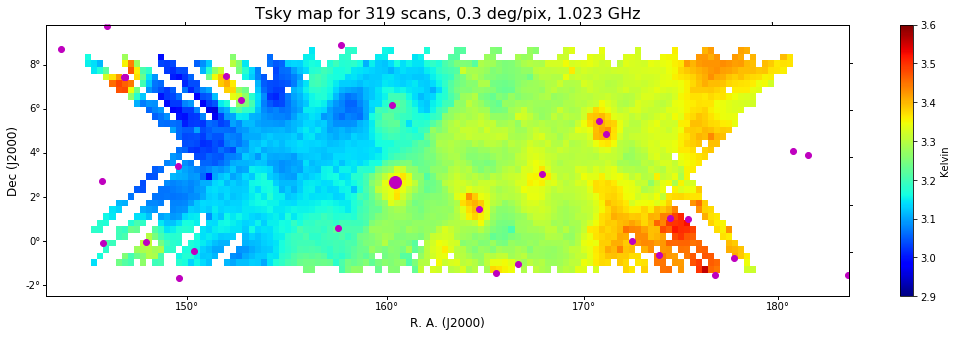

In [14]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap='jet',aspect='auto',vmin=2.9,vmax=3.6)
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)',fontsize=12)
plt.ylabel('Dec (J2000)',fontsize=12)
plt.title('Tsky map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                              +str(round(cal_freq(ch_plot)/1e9,3))+' GHz',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.savefig('Tsky_all_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
plt.show()

In [15]:
np.nanmax(Tresi_xy[:,:,ch_plot])

0.38641267970094573

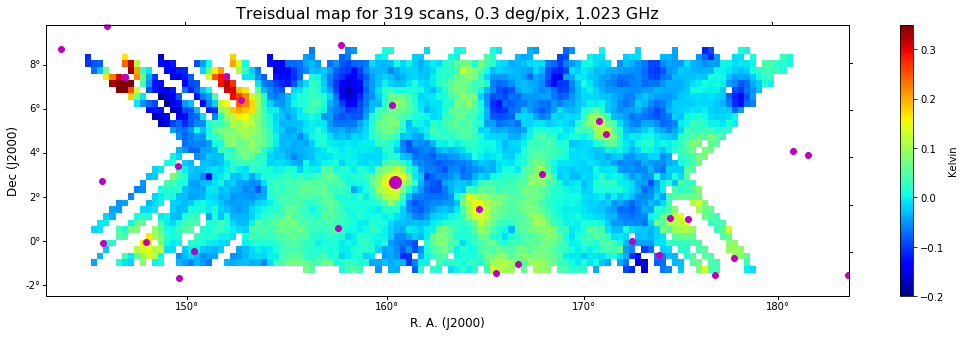

In [16]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap='jet',aspect='auto',vmin=-0.2, vmax=0.35)
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)',fontsize=12)
plt.ylabel('Dec (J2000)',fontsize=12)
plt.title('Treisdual map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                              +str(round(cal_freq(ch_plot)/1e9,3))+' GHz',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.savefig('Tresi_all_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
plt.show()

In [17]:
assert((Npix_xy_count1==Npix_xy_count2).all())
print total_count

371


In [18]:
#save data

list=[Sum_Tsky_xy,Sum_Tresi_xy,Npix_xy_count1,Tsky_xy,Tresi_xy]
list_str=['Sum_Tsky_cube','Sum_Tresi_cube','Npix_count_cube','Tsky_cube','Tresi_cube']
for i in range(len(list)):
    hdu=w.to_fits()
    hdu[0].data=list[i]
    if (std_list0==1000).all()==True:
        hdu.writeto(output_file+'ALL_scan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)
    else:    
        hdu.writeto(output_file+'Nscan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)


# reload data to check 

In [19]:
Fits=output_file+'Nscan'+str(total_count)+'_Tresi_cube_p'+str(pix_deg)+'d.fits'
cube = fits.open(Fits)[0].data
print np.shape(cube)

(133, 41, 4096)


In [20]:
w2=WCS(Fits).dropaxis(-1)
print w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133


In [21]:
#check data
assert((cube[~np.isnan(cube)]==Tresi_xy[~np.isnan(Tresi_xy)]).all()==True)

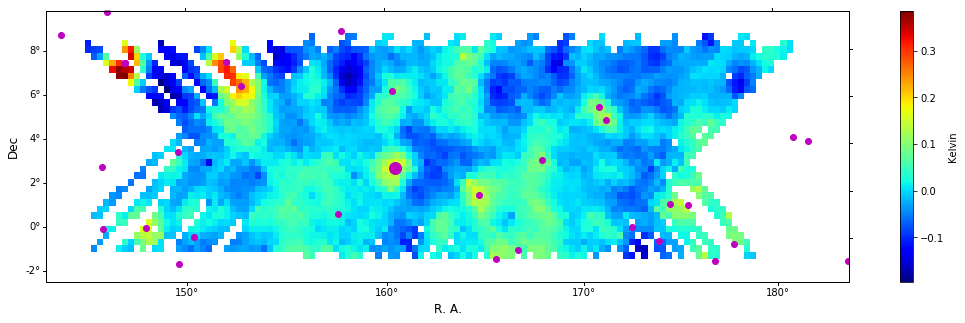

In [22]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w2)
plt.imshow(cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

# the Galactic model

In [23]:
nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
import pysm
from pysm.nominal import models


In [24]:
def cal_Gal_pix (pix_ra, pix_dec, freq, nside):
    sky_config = {
        'synchrotron': models("s1", nside),
    }

    sky = pysm.Sky(sky_config)
    
    c = SkyCoord(ra=pix_ra * u.degree, dec=pix_dec * u.degree, frame='icrs')
    theta = 90 - (c.galactic.b / u.degree).value
    phi = (c.galactic.l / u.degree).value
        
    syn = sky.synchrotron(nu=freq/1e9) / 1e6  # K
    I = hp.pixelfunc.get_interp_val(syn[0, :], theta / 180 * np.pi, phi / 180 * np.pi)
        
    return I


In [25]:
a=np.where(~np.isnan(Tsky_xy[:,:,ch_plot]))
pix_list_x=np.array(a[0])
pix_list_y=np.array(a[1])

In [26]:
pix_radec=pixel_to_skycoord(pix_list_x,pix_list_y,w)
pix_ra,pix_dec=(pix_radec.ra/u.deg).value,(pix_radec.dec/u.deg).value

In [27]:
gal_pix=np.zeros([Npix_x,Npix_y])
gal_pix[np.isnan(Tsky_xy[:,:,ch_plot])]=np.nan
gal_pix[pix_list_x,pix_list_y]=cal_Gal_pix (pix_ra, pix_dec, cal_freq(ch_plot), nside)    


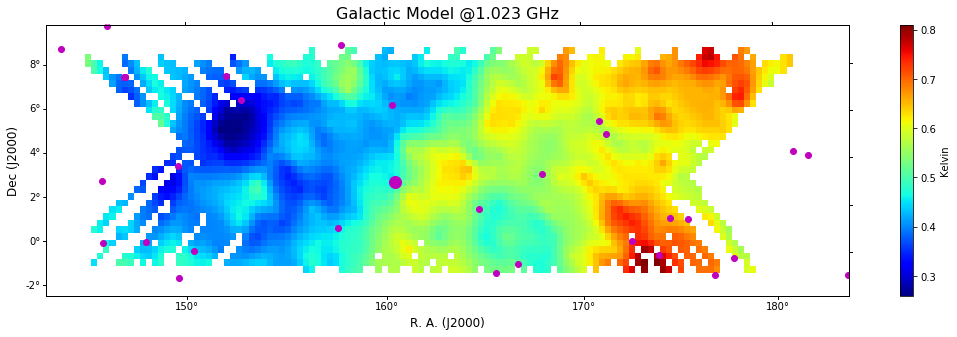

In [28]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.imshow(gal_pix.T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)',fontsize=12)
plt.ylabel('Dec (J2000)',fontsize=12)
plt.title('Galactic Model @'+str(round(cal_freq(ch_plot)/1e9,3))+' GHz',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
#plt.savefig('Tgal_model'+str(ch_plot)+'.pdf', bbox_inches='tight')
plt.show()

# show the per-dish data

In [29]:
print std_list0

[ 0.  0.  0. ...,  0.  0.  0.]


-------------------------------------------
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133
-------------------------------------------
***stastic cubes initialized
# cube 1: 1551037708 m000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in greater


Tresi ch_std range of m000 before channel clean: (0.0154959332132, 0.0592012200169),  of ch800: 0.025868670276
# cube 2: 1551055211 m000
Tresi ch_std range of m000 before channel clean: (0.0219321607571, 0.0396161645055),  of ch800: 0.0273214256521
# cube 3: 1553966342 m000
Tresi ch_std range of m000 before channel clean: (0.021377667316, 0.110528399112),  of ch800: 0.0350333164645
***15 channels deleted
# cube 4: 1554156377 m000
Tresi ch_std range of m000 before channel clean: (0.0178874108884, 0.0410848790106),  of ch800: 0.0278793069043
# cube 5: 1556052116 m000
Tresi ch_std range of m000 before channel clean: (0.0226399812338, 0.0668548681247),  of ch800: 0.0299450843419
# cube 6: 1556138397 m000
Tresi ch_std range of m000 before channel clean: (0.0262526939992, 0.0764483070496),  of ch800: 0.0296455142016
no data cube for 1562857793, m000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in divide


3.04083036039 0.175581501939
0.000589649242319 0.0563832801671


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice


Tresi ch_std of all scans, ch800: 0.0239054650424
no data cube for 1551037708, m001
-------------------------------------------
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133
-------------------------------------------
***stastic cubes initialized
# cube 1: 1551055211 m001
Tresi ch_std range of m001 before channel clean: (0.0299141630714, 0.0779782678624),  of ch800: 0.0346078004075
# cube 2: 1553966342 m001
Tresi ch_std range of m001 before channel clean: (0.0169023517486, 0.150362676513),  of ch800: 0.0173521232212
***1004 channels deleted
# cube 3: 1554156377 m001
Tresi ch_std range of m001 before channel clean: (0.0281108358976, 0.0964380589375),  of ch800: 0.0323114791603
***127 channels deleted
# cube 4: 1556052116 m001
Tresi ch_std range of m001 before channel clean: (0.0360905901497, 0.1828781

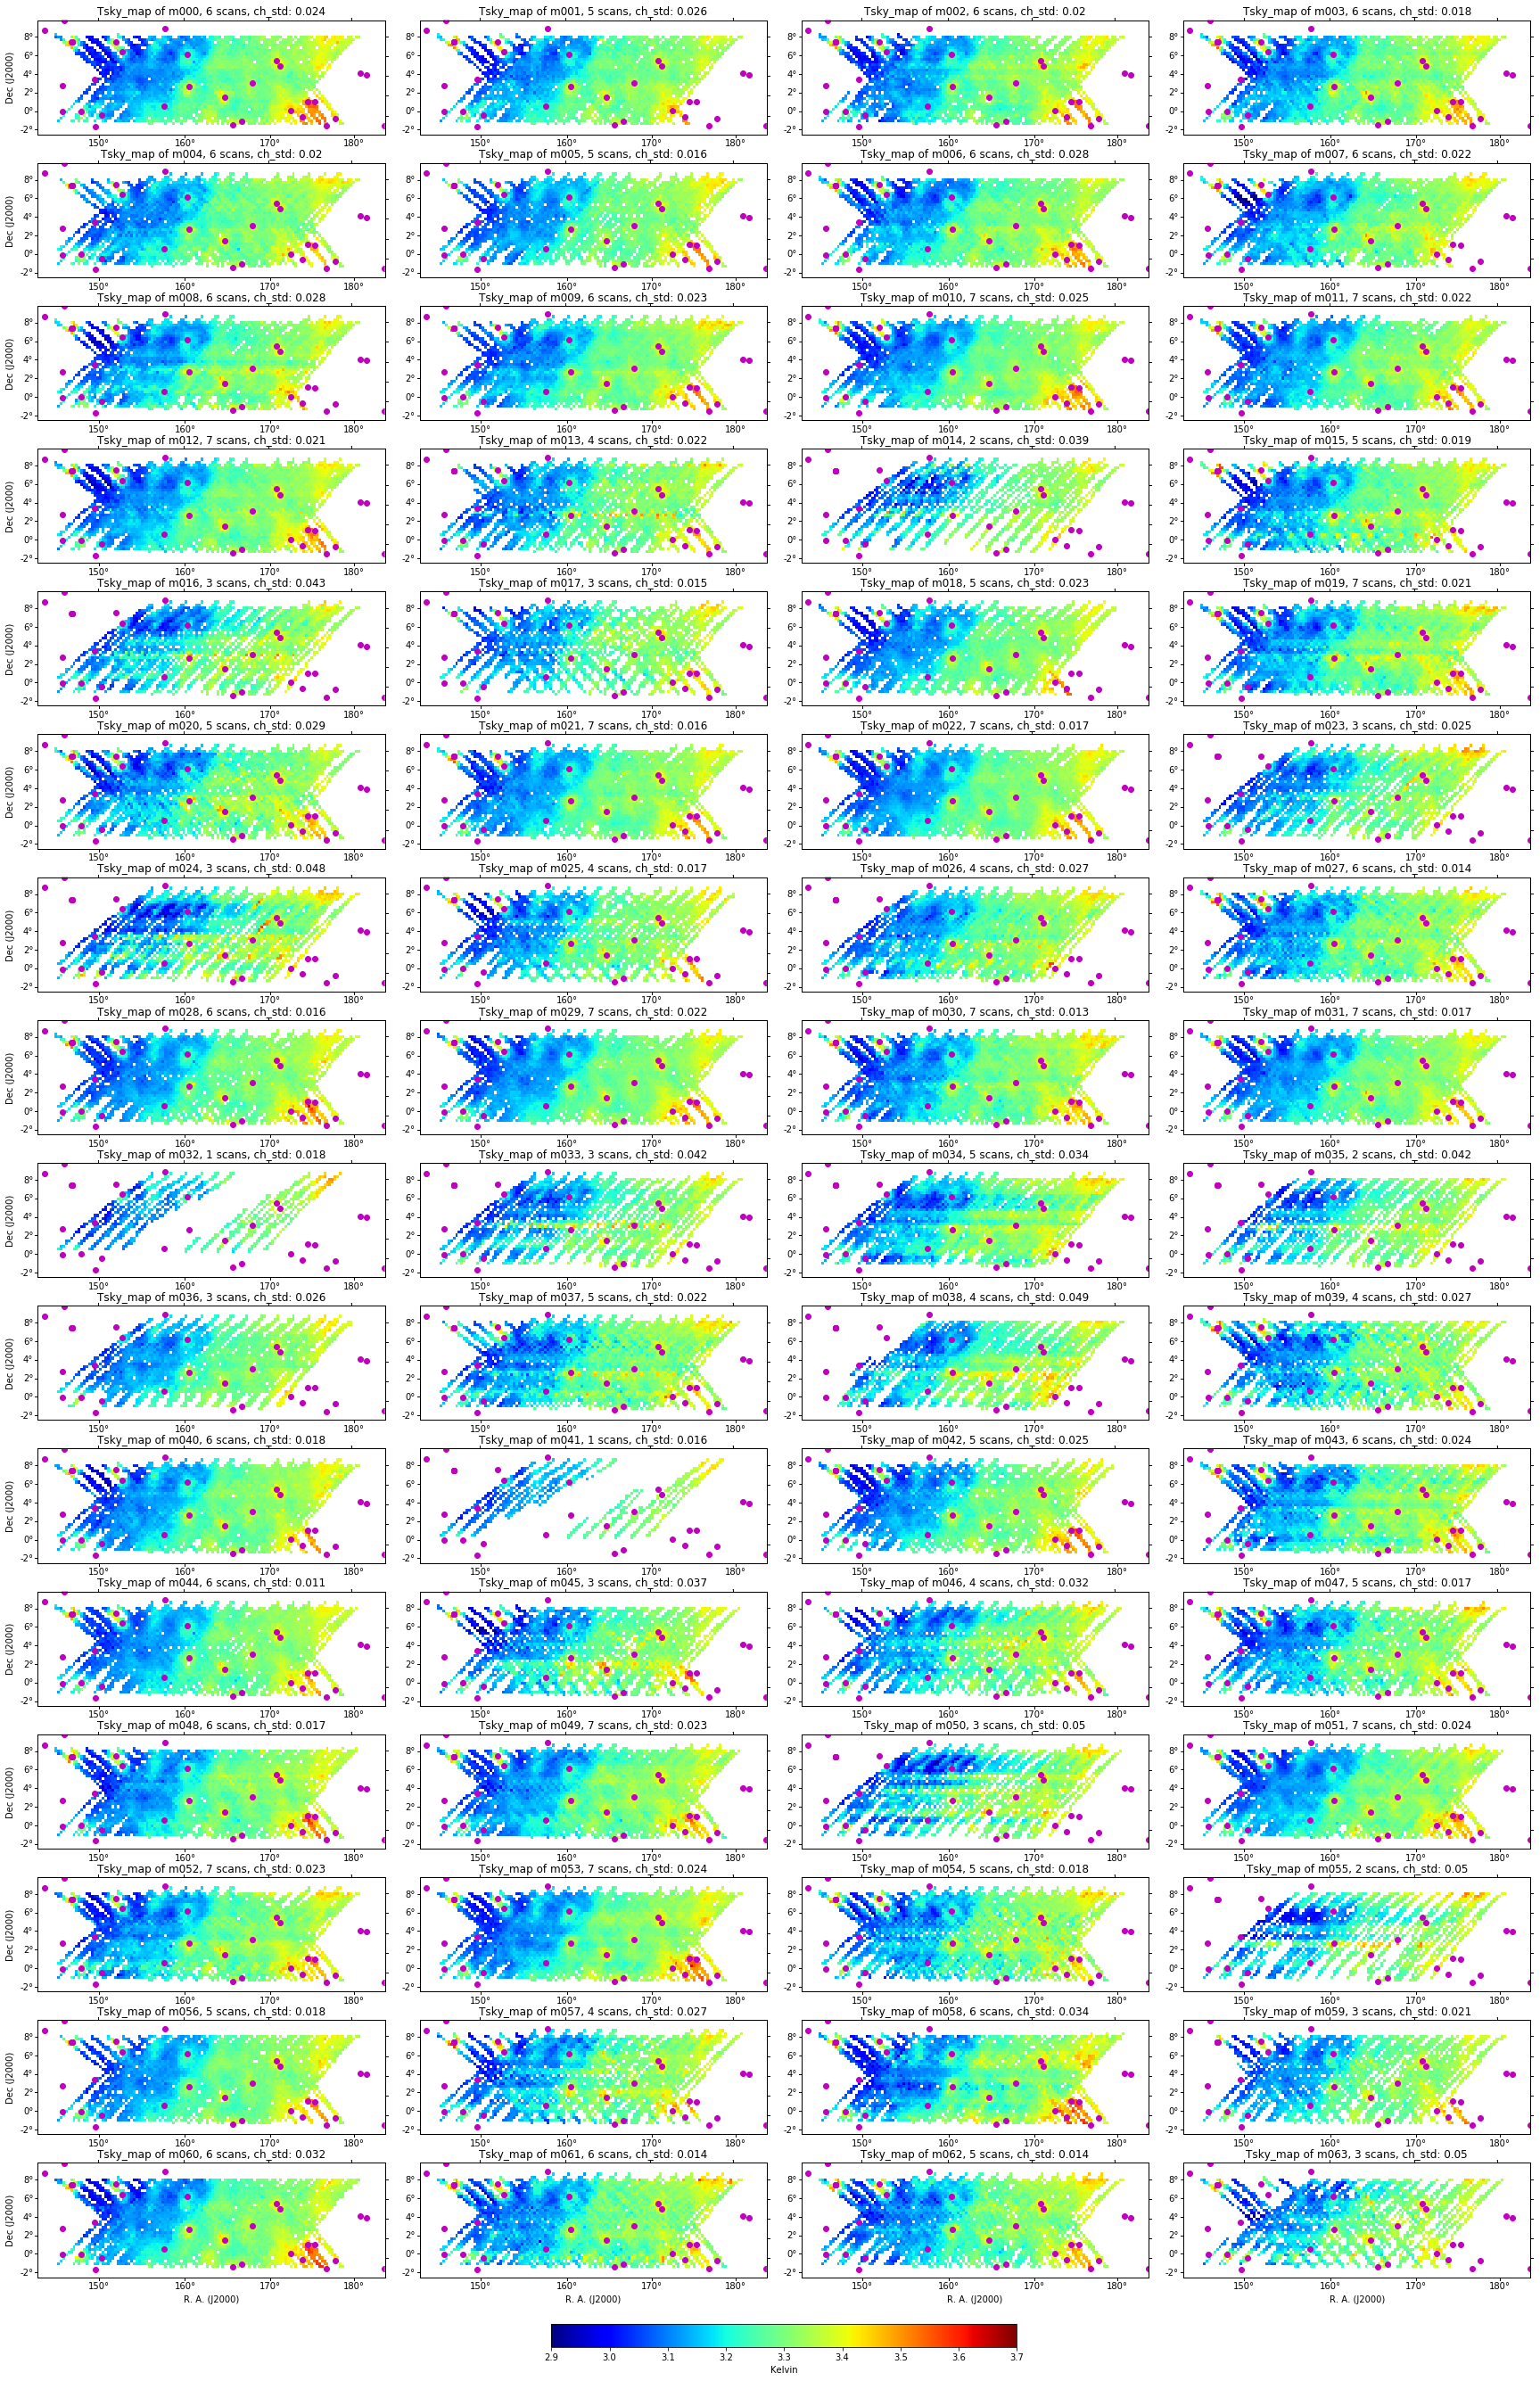

In [30]:
total_count1=0 #cube count
total_count_plot1=0 #channel count

fig =plt.figure(figsize=(30,48))
fig.subplots_adjust (wspace=0.1, hspace=0.25)
axes=[]

for a_i in range(64):
    ant='m'+ "%03d" % a_i
    #print ant
    
    for f_i in range(len(fname_list)):
        fname=fname_list[f_i]
        #print fname
        
        try:

            Fits1='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/Tmap/'+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
            Tsky_cube = fits.open(Fits1)[0].data
            Fits2='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/Tmap/'+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits2)[0].data
            assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
            assert((np.isnan(Tresi_cube)).all()==False)
            total_count1+=1 #cube count
            
            if (total_count1==1):
                Npix_x= np.shape(Tsky_cube)[0]
                Npix_y= np.shape(Tsky_cube)[1]

                w=WCS(Fits1).dropaxis(-1)
                w2=WCS(Fits2).dropaxis(-1)
                assert(w.wcs==w2.wcs)
                print '-------------------------------------------'
                print w
                print '-------------------------------------------'
                fits_temp=np.zeros([Npix_x,Npix_y,4096])

                Sum_Tsky_xy=fits_temp.copy()
                Sum_Tresi_xy=fits_temp.copy()
                Npix_xy_count1=fits_temp.copy()
                Npix_xy_count2=fits_temp.copy()

                print '***stastic cubes initialized'
                
            print '# cube '+str(total_count1)+': '+fname+' '+ant
            assert(np.shape(Tsky_cube)==np.shape(Sum_Tsky_xy))
            
            #mean along dec to check rfi lines
            Tresi_ra_mean=np.nanmean(Tresi_cube,axis=0) #always check Tresi since Tsky have the Galactic slope 
            ch_std=np.nanstd(Tresi_ra_mean,axis=0) 
            print 'Tresi ch_std range of '+ ant +' before channel clean: ('+ str(np.nanmin(ch_std))+', '+str(np.nanmax(ch_std))+'), ',
            print 'of ch'+str(ch_plot)+': '+ str(ch_std[ch_plot])
            
            #delete bad channels
            lim_list=std_list0*5.
            ch_drop=np.where(ch_std>lim_list)[0] 
            
            if len(ch_drop)>0:
                Tsky_cube[:,:,ch_drop]=np.nan            
                Tresi_cube[:,:,ch_drop]=np.nan
                print '***'+str(len(ch_drop))+' channels deleted'
                        
            Sum_Tsky_xy[~np.isnan(Tsky_cube)]+=Tsky_cube[~np.isnan(Tsky_cube)]
            Sum_Tresi_xy[~np.isnan(Tresi_cube)]+=Tresi_cube[~np.isnan(Tresi_cube)]
            Npix_xy_count1[~np.isnan(Tsky_cube)]+=1
            Npix_xy_count2[~np.isnan(Tresi_cube)]+=1
            if (np.isnan(Tsky_cube[:,:,ch_plot])).all()==False: #channel count
                total_count_plot1+=1
            
        except IOError:
            print 'no data cube for '+ fname+', '+ant

    Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
    Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

    print np.nanmean(Tsky_xy),np.nanstd(Tsky_xy)
    print np.nanmean(Tresi_xy),np.nanstd(Tresi_xy)
    
    Tresi_ra_mean=np.nanmean(Tresi_xy,axis=0) #always check Tresi since Tsky have the Galactic slope 
    ch_std=np.nanstd(Tresi_ra_mean,axis=0) 
    print 'Tresi ch_std of all scans, ch'+str(ch_plot)+': '+ str(ch_std[ch_plot])
    
    ###make 64 subplot#########
    ax = plt.subplot(16,4,a_i+1,projection=w)
    axes.append(ax)
    
    im = ax.imshow(Tsky_xy[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=2.9,vmax=3.7)
    ax.set_title('Tsky_map of '+ant+', '+str(total_count_plot1)+ ' scans, ch_std: '
                    + str(round(ch_std[ch_plot],3)), fontsize=12)
    '''
    im = ax.imshow(Tresi_xy[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=-0.25,vmax=0.35)
    ax.set_title('Tresi_map of '+ant+', '+str(total_count_plot1)+ ' scans, ch_std: '
                    + str(round(ch_std[ch_plot],3)), fontsize=12)
    '''
    ax.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    ax.set_xlim([0,Npix_x])
    ax.set_ylim([0,Npix_y])
    #plt.colorbar()
    if a_i%4==0:
        ax.set_ylabel('Dec (J2000)')
    if a_i>59:
        ax.set_xlabel('R. A. (J2000)')
    #reset for each dish
    total_count1=0
    total_count_plot1=0
fig.colorbar(im, ax=axes,orientation="horizontal",fraction=0.01,label='Kelvin',pad=0.02)
plt.savefig('Tsky64_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
#plt.savefig('Tresi64_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
plt.show()

In [31]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Tue May 26 23:05:14 2020#
